In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys

projRootPath =  os.path.abspath(os.path.join('.' ,"../.."))
print("Project root path is: ", projRootPath)
sys.path.append(projRootPath)

from src.utils.path_manipulation import contains_filetype
from src.utils.viz_functions import make_mel_spectrogram
from src.utils.sound_functions import mix_samples, read_mp3, write_mp3, pad_length_to_max

# modules for visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# modules for data processing
import numpy as np
from scipy import signal
from scipy.io import wavfile
import wave
import struct
import csv
import random
from sklearn.preprocessing import StandardScaler

# modules for data mining
from sklearn.decomposition import pca, FastICA

# and IPython.display for audio output
from tqdm.notebook import tqdm 
import IPython.display

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

from pydub import AudioSegment

Project root path is:  D:\Programming\AudioMining


In [3]:
# Get data files
dataDirName = "data"
# rawDataDirName = os.path.join("raw", "mp3")
rawDataDirName = "converted_wav"
className1 = "violin"
className2 = "guitar"
data_path1 = os.path.join(projRootPath, dataDirName, rawDataDirName, className1)
data_path2 = os.path.join(projRootPath, dataDirName, rawDataDirName, className2)

# Get all files from data_path 
# r=root, d=directories, f = files
file_extension = ".wav"
(_, d, allFiles) = next(os.walk(data_path1))
soundFiles1 = [f for f in allFiles if f.endswith(file_extension)]

(_, d, allFiles) = next(os.walk(data_path2))
soundFiles2 = [f for f in allFiles if f.endswith(file_extension)]

In [4]:
# Get data files
dataDirName = "data"
# rawDataDirName = os.path.join("raw", "mp3")
rawDataDirName = "converted_wav"
className1 = "violin"
className2 = "guitar"
data_path1 = os.path.join(projRootPath, dataDirName, rawDataDirName, className1)
data_path2 = os.path.join(projRootPath, dataDirName, rawDataDirName, className2)

# Get all files from data_path 
# r=root, d=directories, f = files
file_extension = ".wav"
(_, d, allFiles) = next(os.walk(data_path1))
soundFiles1 = [f for f in allFiles if f.endswith(file_extension)]

(_, d, allFiles) = next(os.walk(data_path2))
soundFiles2 = [f for f in allFiles if f.endswith(file_extension)]

In [5]:
sdata1 = []
sampleRates1 = []
soundFiles = soundFiles1
for indx, file in tqdm(enumerate(soundFiles)):
    fpath = os.path.join(data_path1, file)
#     soundSample, fs = read_mp3(fpath)
    fs, soundSample = wavfile.read(fpath)
    sdata1.append(soundSample)
    sampleRates1.append(fs)
        

In [6]:
sdata2 = []
sampleRates2 = []
soundFiles = soundFiles2
for indx, file in tqdm(enumerate(soundFiles)):
    fpath = os.path.join(data_path2, file)
#     soundSample, fs = read_mp3(fpath)
    fs, soundSample = wavfile.read(fpath)
    sdata2.append(soundSample)
    sampleRates2.append(fs)

print(sdata2[:3])


[array([0, 0, 0, ..., 0, 0, 0], dtype=int16), array([0, 0, 0, ..., 0, 0, 0], dtype=int16), array([0, 0, 0, ..., 0, 0, 0], dtype=int16)]


In [7]:
### Check that sampling rate is the same
print(min(sampleRates1) == max(sampleRates1))
print(min(sampleRates2) == max(sampleRates2))

True
True


In [8]:
## Select only the samples shorter than threshold
lenThreshold = 300000
sdata1 = [x for x in sdata1 if len(x) <= lenThreshold]
sdata2 = [x for x in sdata2 if len(x) <= lenThreshold]

random.shuffle(sdata1)
random.shuffle(sdata2)

## Pad the length of the samples for matrix building
sdata1 = pad_length_to_max(sdata1, lenThreshold)
sdata2 = pad_length_to_max(sdata2, lenThreshold)

trainset1 = sdata1[:50]
trainset2 = sdata2[:50]

valset1 = sdata1[50:100]
valset2 = sdata2[50:]

# subset1 = random.sample(sdata1, 50)
# subset2 = random.sample(sdata2, 50)




In [9]:
print(min(trainset1[0]), max(trainset1[0]))

-4970 5686


In [10]:
mixed_samples = []
for i1, s1 in tqdm(enumerate(trainset1)):
    for i2, s2 in enumerate(trainset2):
        mixed_samples.append(mix_samples(s1, s2))
        
                             
print(mixed_samples[:3])        


[array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])]


In [11]:
def generate_mixtures(s1, s2, mixing_matrix):
    S = np.c_[s1, s2]
    S = StandardScaler().fit_transform(S)
    A = np.array(mixing_matrix)
    X = np.dot(S, A.T)
    return S, X
    

#### 

c:\users\marius\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


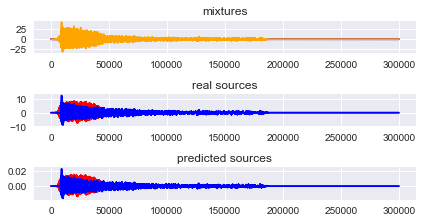

[[ 532.84016269  561.6694673 ]
 [ 251.7203445   828.3600004 ]
 [1050.98058854 1670.86420135]]


In [12]:
s1 = trainset1[0]
s2 = trainset2[0]

mixt_mtx = [[1, 1], [0.5, 1.5], [2, 3]]
S, mixts = generate_mixtures(s1, s2, mixt_mtx)

# print(mixts.shape)

ica = FastICA(n_components=2)
S_ = ica.fit_transform(mixts) # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

fig = plt.figure()
models = [mixts, S, S_]
names = ['mixtures', 'real sources', 'predicted sources']
colors = ['red', 'blue', 'orange']
for i, (name, model) in enumerate(zip(names, models)):
    plt.subplot(4, 1, i+1)
    plt.title(name)
    for sig, color in zip (model.T, colors):
        plt.plot(sig, color=color)
        
fig.tight_layout()        
plt.show()

print(A_)

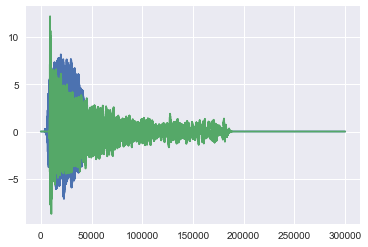

In [13]:
plt.plot(S)

In [14]:
print(S[:, 0])

[5.41831076e-05 5.41831076e-05 5.41831076e-05 ... 5.41831076e-05
 5.41831076e-05 5.41831076e-05]


In [15]:
IPython.display.Audio(S[:, 0], rate=sampleRates1[2])

In [16]:
IPython.display.Audio(S_[:, 0], rate=sampleRates1[2])

In [17]:
training_mixtures = np.asarray(mixed_samples)

In [ ]:
# print(mixts.shape)

ica = FastICA(n_components=2)
S_ = ica.fit_transform(training_mixtures.T) # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix


print(A_)

In [ ]:
fig = plt.figure()
models = [mixts, S, S_]
names = ['mixtures', 'real sources', 'predicted sources']
colors = ['red', 'blue', 'orange']
for i, (name, model) in enumerate(zip(names, models)):
    plt.subplot(4, 1, i+1)
    plt.title(name)
    for sig, color in zip (model.T, colors):
        plt.plot(sig, color=color)
        
fig.tight_layout()        
plt.show()
